In [ ]:
# !pip install transformers
from google.colab import drive
drive.mount('/content/drive')
from transformers import pipeline
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import nltk
nltk.download('punkt')
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


GPU is available


In [ ]:
# df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/EBAC Sem4/practice project/labelled_dataset_gpt4o.csv')
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/EBAC Sem4/practice project/labelled_dataset_sentence_level_clean.csv')

In [ ]:
################ using NLI zero shot classifier

tokenizer = AutoTokenizer.from_pretrained("roberta-large-mnli")
model = AutoModelForSequenceClassification.from_pretrained("roberta-large-mnli")
sentiment_analyzer = pipeline("zero-shot-classification", model=model, tokenizer=tokenizer, device=0)
candidate_labels = ["POSITIVE", "NEUTRAL", "NEGATIVE"]

# List to store the results
results = []

def truncate_to_max_length(text, max_length):
    encoded_input = tokenizer(text, truncation=True, max_length=max_length, return_tensors='pt')
    return tokenizer.decode(encoded_input['input_ids'][0], skip_special_tokens=True)

for index, row in tqdm(df.iterrows(), total=len(df), ncols=100):
    review = row['sentence']
    label = row['label']
    # subreddit = row['subreddit']
    # created_utc = row['created_utc']

    # Sentence tokenization
    for sentence in sent_tokenize(review):
        truncated_sentence = truncate_to_max_length(sentence, max_length=512)

        # Get sentiment for the sentence using zero-shot classification
        sentiment_result = sentiment_analyzer(truncated_sentence, candidate_labels)

        # Append results
        results.append({
            # "subreddit": subreddit,
            # "created_utc": created_utc,
            "sentence": sentence,
            "prediction": sentiment_result['labels'][0],
            "sentiment_score": sentiment_result['scores'][0],
            "label": label
        })

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████| 8313/8313 [08:35<00:00, 16.11it/s]


In [ ]:
sentiment_df = pd.DataFrame(results)
# sentiment_df.to_csv('/content/drive/My Drive/Colab Notebooks/EBAC Sem4/practice project/Roberta_scoring_dataset.csv',index = False)
sentiment_df.to_csv('/content/drive/My Drive/Colab Notebooks/EBAC Sem4/practice project/Roberta_scoring_dataset_sentence_level.csv',index = False)

In [ ]:
# sentiment_df= pd.read_csv('/content/drive/My Drive/Colab Notebooks/EBAC Sem4/practice project/Roberta_scoring_dataset.csv')
sentiment_df= pd.read_csv('/content/drive/My Drive/Colab Notebooks/EBAC Sem4/practice project/Roberta_scoring_dataset_sentence_level.csv')

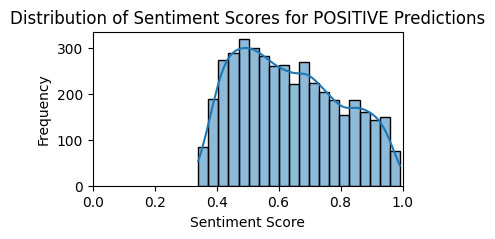

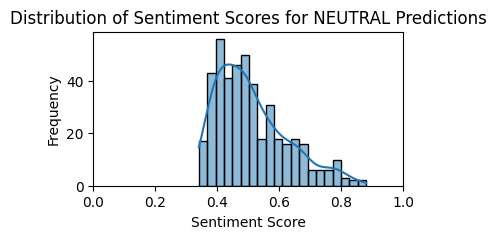

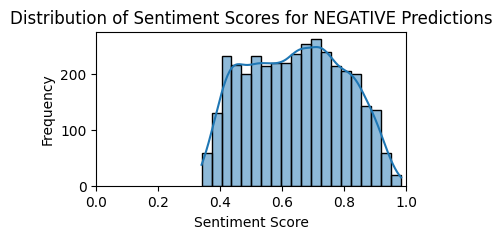

In [ ]:
def plot_sentiment_distribution(sentiment_df, sentiment_category):
    # Filter the DataFrame for the specified sentiment category
    filtered_df = sentiment_df[sentiment_df['prediction'] == sentiment_category]

    # Create the histogram for sentiment scores
    plt.figure(figsize=(4, 2))
    sns.histplot(filtered_df['sentiment_score'], bins=20, kde=True)

    # Add labels and title
    plt.title(f'Distribution of Sentiment Scores for {sentiment_category} Predictions')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)  # Assuming sentiment scores range from 0 to 1
    plt.show()

# Plot distributions for each sentiment category
for category in ['POSITIVE', 'NEUTRAL', 'NEGATIVE']:
    plot_sentiment_distribution(sentiment_df, category)

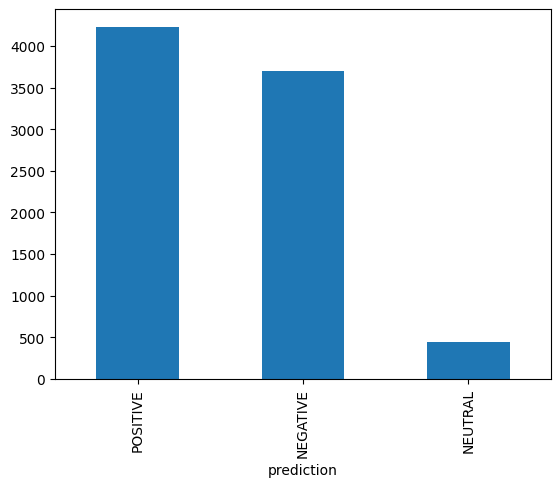

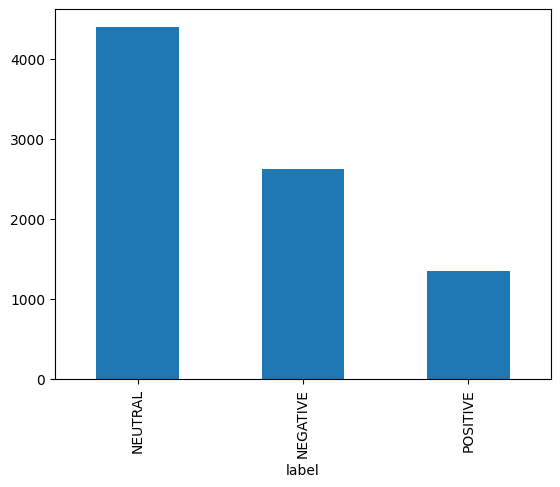

label
NEUTRAL     4401
NEGATIVE    2623
POSITIVE    1345
Name: count, dtype: int64
prediction
POSITIVE    4231
NEGATIVE    3694
NEUTRAL      444
Name: count, dtype: int64


In [ ]:
sentiment_df['prediction'].value_counts().plot(kind='bar')
plt.show()
sentiment_df['label'].value_counts().plot(kind='bar')
plt.show()
print(sentiment_df['label'].value_counts())
print(sentiment_df['prediction'].value_counts())

Accuracy: 0.45
Recall: 0.45
F1 Score: 0.36


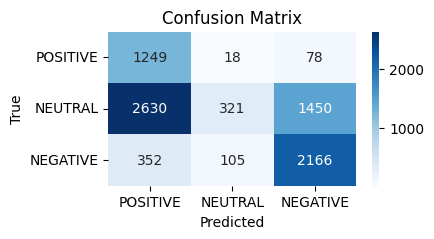

In [ ]:
predictions = sentiment_df['prediction']
labels = sentiment_df['label']

cm = confusion_matrix(labels, predictions, labels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])

accuracy = accuracy_score(labels, predictions)
recall = recall_score(labels, predictions, average='weighted')
f1 = f1_score(labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'], yticklabels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.86
Recall: 0.86
F1 Score: 0.88


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


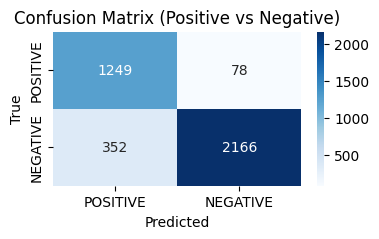

In [ ]:
filtered_labels = sentiment_df[sentiment_df['label'].isin(['POSITIVE', 'NEGATIVE'])]
predictions = filtered_labels['prediction']
labels = filtered_labels['label']

# Compute the confusion matrix
cm = confusion_matrix(labels, predictions, labels=['POSITIVE', 'NEGATIVE'])

# Calculate metrics
accuracy = accuracy_score(labels, predictions)
recall = recall_score(labels, predictions, average='weighted')
f1 = f1_score(labels, predictions, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot the confusion matrix
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['POSITIVE', 'NEGATIVE'], yticklabels=['POSITIVE', 'NEGATIVE'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Positive vs Negative)')
plt.show()